<a href="https://colab.research.google.com/github/MarufAnsari/Coursera_Capstone/blob/master/The_Battle_of_Neighborhoods%2C_New_York_City_vs_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Battle of Neighborhoods : Toronto vs New York City**

The aim of this project is to explore the neighborhoods of two major economic capitals, Toronto (CA) and New York City (USA), and group them by common nearby venues. In this project i have compared the neighborhoods of both the cities with respect to places to eat, better connectivity to several useful regions and how they are distributed around both cities. The places I considered are airports, metros, coffee-shops, restaurants, schools, colleges, general stores, hospitals etc.


##**1. Importing necessary libraries**

In [ ]:
import numpy as np                # library to handle data in a vectorized manner
import pandas as pd               # library for data analsysis
import requests                   # library to handle requests
from bs4 import BeautifulSoup     # library to parse HTML and XML documents

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json                                   # library to handle JSON files
from geopy.geocoders import Nominatim         # convert an address into latitude and longitude values
from pandas.io.json import json_normalize     # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

print('Libraries imported.')

##**2. Uploading and Cleaning the Datasets using Pandas**

###**(A) Toronto Dataset**

**Scrap data from Wikipedia page into a DataFrame**

The  data set for Toronto is available at wikipedia. It includes postal-code, boroughs and neighborhood names. Along with it we have to add location coordinates of each neighborhood, which i found on a coursera given link.

Get the HTML page of Wikipedia showing the data of Toronto city.

We will use read_html function here in order to convert the html data into list of Dataframe objects.

We will remove the rows with not assigned boroughs




In [ ]:
# requesting to get the html page from the URL/Link
wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text


# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(wiki_page, 'html.parser') 

#Lists to store the table data
PostalCode_ = []
Borough_ = []
Neighborhood_ = []

#appending data into lists
for row in soup.find('table').find_all('tr') :
  cells = row.find_all('td')
  if(len(cells)>0) :
    PostalCode_.append(cells[0].text.rstrip('\n'))
    Borough_.append(cells[1].text.rstrip('\n'))
    Neighborhood_.append(cells[2].text.rstrip('\n'))

#creating Dataframe by concatconcatenating the lists
toronto_df = pd.DataFrame({"PostalCode":PostalCode_, "Borough":Borough_, "Neighborhood":Neighborhood_})
print(toronto_df.shape)
toronto_df.head()

(180, 3)


,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


**Dropping the cells with a borough that is "Not assigned"**



In [ ]:
# dropping "Not assigned" borough
toronto_df['Borough'].replace('Not assigned', np.nan, inplace=True)
toronto_df.dropna(subset=['Borough'], inplace=True)
print(toronto_df.shape)
toronto_df.head()

(103, 3)


,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


**Group Neighborhoods in the same borough**

In [ ]:
# Grouping by Borough and Postaal-Code
toronto_df_grp = toronto_df.groupby(['PostalCode','Borough'], as_index=False).agg(lambda x: ','.join(x))
toronto_df_grp.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


**"Not assigned" Neighborhood is replaced with respective borough name**

In [ ]:
# replacing "Not assigned" Neighborhood
for index, row in toronto_df_grp.iterrows() :
  if row['Neighborhood'] == 'Not assigned' :
    row['Neighborhood'] = row['Borough']

toronto_df_grp.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


**Load co-ordinates from the csv file of coursera**

In [ ]:
#loading co-ordinates
geo_tdf = pd.read_csv('http://cocl.us/Geospatial_data')
geo_tdf.columns = ['PostalCode', 'Latitude', 'Longitude']
geo_tdf.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Merge two tables of data and co-ordinates on Postal-Code**

In [ ]:
toronto_df_new = toronto_df_grp.merge(geo_tdf, on='PostalCode', how='left')
toronto_df_new = toronto_df_new.drop(['PostalCode'],1)
toronto_df_new.head()

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [ ]:
# Shape of our table
print('Shape of Toronto dataframe is {} with {} unique boroughs and {} neighborhoods.'.format(
        toronto_df_new.shape, len(toronto_df_new['Borough'].unique()), toronto_df_new.shape[0] ))

Shape of Toronto dataframe is (103, 4) with 10 unique boroughs and 103 neighborhoods.


###**(B) New York City Dataset**

The data set for New York wis given by coursera. It includes boroughs, neighborhood names and location of each neighborhood.

Donwload the data files and place it on the server, so we can simply run a wget command and access the data.

In [ ]:
#Dataframe extraction for New York
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


**Load and explore the data**


In [ ]:
with open('newyork_data.json') as json_data:
    newyork = json.load(json_data)

**Tranform the data into a pandas dataframe**

Let's loop through the data and fill the dataframe one row at a time

In [ ]:
newyork_data = newyork['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_df_new = pd.DataFrame(columns=column_names)

for data in newyork_data:
    borough = newyork_name = data['properties']['borough'] 
    newyork_name = data['properties']['name']
        
    newyork_loc = data['geometry']['coordinates']
    newyork_lat = newyork_loc[1]
    newyork_lon = newyork_loc[0]
    
    newyork_df_new = newyork_df_new.append({'Borough': borough,
                                          'Neighborhood': newyork_name,
                                          'Latitude': newyork_lat,
                                          'Longitude': newyork_lon}, ignore_index=True)
    
newyork_df_new.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [ ]:
#Shape of our table
print('Shape of New York dataframe is {} with {} unique boroughs and {} neighborhoods.'.format(
        newyork_df_new.shape, len(newyork_df_new['Borough'].unique()), newyork_df_new.shape[0] ))

Shape of New York dataframe is (306, 4) with 5 unique boroughs and 306 neighborhoods.


##**3. Mapping out the nieghborhoods in both cities-Initial Visual Analysis with Folium and Geopy**

Here we took initial visualization of the neighborhood dataset for both the cities with a folium map in order to understand the layout of the neighborhoods and their location in the respective cities.


###**(A) Toronto Map**

**Use geopy library to get the co-ordinates of Toronto**

In [ ]:
#getting geographical co-ordinates
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude_t = location.latitude
longitude_t = location.longitude
print("The geographical co-ordinates of Toronto is {}, {}".format(latitude_t, longitude_t))

The geographical co-ordinates of Toronto is 43.6534817, -79.3839347


**Create a map of Toronto with Neighborhoods superimposed on the top**

In [ ]:
# plotting map of Toronto based on co-ordinates
map_toronto = folium.Map(location=[latitude_t, longitude_t], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'],toronto_df_new['Longitude'],toronto_df_new['Borough'],toronto_df_new['Neighborhood']):
  label = '{},{}'.format(neighborhood,borough)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker([lat,lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7).add_to(map_toronto)

map_toronto

###**(A) New York Map**

**Use geopy library to get the co-ordinates of New York**

In [ ]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude_ny, longitude_ny))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


**Create a map of New York with Neighborhoods superimposed on the top**

In [ ]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_df_new['Latitude'], newyork_df_new['Longitude'], newyork_df_new['Borough'], newyork_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

##**4. Use Foursquare API to explore the neighborhoods**

We have used the Foursquare API to analyze the nearby places to these neighborhoods and see the proximity of important places from the corresponding neighborhoods


In [111]:
# Define foursquare credentials and version
CLIENT_ID = 'F0CGGFPMVAL3GVT0QRCNQBICT5ECO2AS1JBAGXLGHPFAEYI3'
CLIENT_SECRET = 'TEHXGMHAFUH5BIKCW4LYLS2V2NYENO3L2SXXPURDGSANLRJM'
VERSION = '20180605'    # API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F0CGGFPMVAL3GVT0QRCNQBICT5ECO2AS1JBAGXLGHPFAEYI3
CLIENT_SECRET:TEHXGMHAFUH5BIKCW4LYLS2V2NYENO3L2SXXPURDGSANLRJM


Now Let's get the top 100 venues for all the neighborhoods of cities within a radius of 500m

In [109]:
LIMIT = 100
radius = 500

def getNearbyVenues(boroughs, neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for lat, lng, borough, neighborhood in zip(latitudes, longitudes, boroughs, neighborhoods):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough, neighborhood, 
            lat, lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

In [ ]:
# Venues near New York city neighborhoods
newyork_venues = getNearbyVenues(boroughs=newyork_df_new['Borough'], neighborhoods=newyork_df_new['Neighborhood'],
                                 latitudes=newyork_df_new['Latitude'], longitudes=newyork_df_new['Longitude'])


In [ ]:
# Venues near Toronto neighborhoods
toronto_venues = getNearbyVenues(boroughs=toronto_df_new['Borough'], neighborhoods=toronto_df_new['Neighborhood'],
                                 latitudes=toronto_df_new['Latitude'], longitudes=toronto_df_new['Longitude'])

In [114]:
print("Number of venues at Toronto city: ",toronto_venues.shape,"\nNumber of venues at New York city: ",newyork_venues.shape)

Number of venues at Toronto city:  (2140, 8) 
Number of venues at New York city:  (10046, 8)


For analyzing the neighborhoods of Toronto and New York, we have been able to generate a list of popular/trending places near each neighborhood based on the corresponding map coordinates in the data sets using the explore section of the Foursquare API.


In [115]:
toronto_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


In [116]:
newyork_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
3,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Bronx,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station


After it, we have generated tables showing the number of venues in each of the boroughs and then visualize them using a bar chart of matplotlib library to get a better idea about it.

In [117]:
#Total venues in each borough of toronto city
toronto_unique_venues = toronto_venues.groupby(['Borough']).count()
toronto_unique_venues.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude'], inplace=True)
toronto_unique_venues

,Venue Category
Borough,
Central Toronto,112
Downtown Toronto,1239
East Toronto,124
East York,74
Etobicoke,75
Mississauga,12
North York,238
Scarborough,89
West Toronto,159


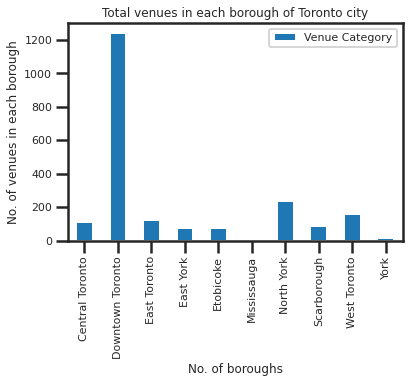

In [118]:
import matplotlib.pyplot as plt

toronto_unique_venues.plot(kind="bar")
plt.title("Total venues in each borough of Toronto city")
plt.xlabel("No. of boroughs")
plt.ylabel("No. of venues in each borough")
plt.show()

In [119]:
#Total venues in each borough of new york city
newyork_unique_venues = newyork_venues.groupby(['Borough']).count()
newyork_unique_venues.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude'], inplace=True)
newyork_unique_venues

,Venue Category
Borough,
Bronx,1197
Brooklyn,2742
Manhattan,3181
Queens,2093
Staten Island,833


Let's find out the number of unique venue categories

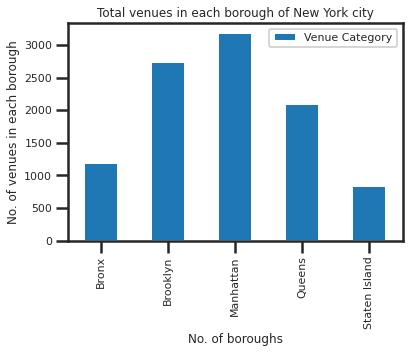

In [120]:
newyork_unique_venues.plot(kind="bar")
plt.title("Total venues in each borough of New York city")
plt.xlabel("No. of boroughs")
plt.ylabel("No. of venues in each borough")
plt.show()

In [121]:
print("There are", len(toronto_venues['Venue Category'].unique()), "unique venue categories in Toronto")
print("There are", len(newyork_venues['Venue Category'].unique()), "unique venue categories in New York")

There are 267 unique venue categories in Toronto
There are 428 unique venue categories in New York


Neighborhoods of Toronto that have atleast one venue

In [122]:
toronto_grouped = toronto_venues.drop(['Venue Name','Venue Latitude','Venue Longitude','Venue Category'],1)
toronto_grouped.sort_values("Neighborhood", inplace = True) 
  
# dropping All duplicte values 
toronto_grouped.drop_duplicates(subset ="Neighborhood", keep = 'first', inplace = True, ignore_index=True)
print(toronto_grouped.shape)
toronto_grouped.head()

(97, 4)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Scarborough,Agincourt,43.794200,-79.262029
1,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
2,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259
3,North York,Bayview Village,43.786947,-79.385975
4,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750


Neighborhoods of New York that have atleast one venue

In [123]:
newyork_grouped = newyork_venues.drop(['Venue Name','Venue Latitude','Venue Longitude','Venue Category'],1)
newyork_grouped.sort_values("Neighborhood", inplace = True) 
  
# dropping All duplicte values 
newyork_grouped.drop_duplicates(subset ="Neighborhood", keep = 'first', inplace = True, ignore_index=True)
print(newyork_grouped.shape)
newyork_grouped.head()

(302, 4)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Bronx,Allerton,40.865788,-73.859319
1,Staten Island,Annadale,40.538114,-74.178549
2,Staten Island,Arden Heights,40.549286,-74.185887
3,Staten Island,Arlington,40.635325,-74.165104
4,Staten Island,Arrochar,40.596313,-74.067124


##**5. Analyze Each Neighborhood**

Here we have generated tables for the top 10 most common venues around each of the neighborhoods of both the cities by using one hot encoding and then display them after grouping them on neighborhoods

In [124]:
# one hot encoding for Toronto
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough, neighborhood back to the dataframe
toronto_onehot['Borough'] = toronto_venues['Borough']
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# move borough, neighborhood to the first column
fixed_columns = list(toronto_onehot.columns[-1:]) + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.shape

(2140, 268)

In [125]:
#grouping neighborhoods and taking mean of their frequency
toronto_onehot_grp = toronto_onehot.groupby(['Borough','Neighborhood']).mean().reset_index()
print(toronto_onehot_grp.shape)
toronto_onehot_grp.head()

(97, 268)


,Borough,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,Davisville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0303

In [126]:
# one hot encoding for New york
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough, neighborhood back to the dataframe
newyork_onehot['Borough'] = newyork_venues['Borough']
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood']

# move borough, neighborhood to the first column
fixed_columns = list(newyork_onehot.columns[-2:]) + list(newyork_onehot.columns[:-2])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.shape

(10046, 429)

In [127]:
#grouping neighborhoods and taking mean of their frequency
newyork_onehot_grp = newyork_onehot.groupby(['Borough','Neighborhood']).mean().reset_index()
newyork_onehot_grp.drop_duplicates(subset ="Neighborhood", keep = 'first', inplace = True, ignore_index=True)
print(newyork_onehot_grp.shape)
newyork_onehot_grp.head()

(302, 429)


,Borough,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Opt

Now Let's display the top 10 venues for each Neighborhood

In [128]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [129]:
# Top 10 venues for the neighborhoods of Toronto
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areacolumns = ['Borough','Neighborhood']
freqcolumns = []
for ind in np.arange(num_top_venues):
    try:
        freqcolumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqcolumns.append('{}th Most Common Venue'.format(ind+1))
columns = areacolumns+freqcolumns

# create a new dataframe
neighborhoods_venues_sorted_toronto = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_toronto['Borough'] = toronto_onehot_grp['Borough']
neighborhoods_venues_sorted_toronto['Neighborhood'] = toronto_onehot_grp['Neighborhood']

for ind in np.arange(toronto_onehot_grp.shape[0]):
    neighborhoods_venues_sorted_toronto.iloc[ind, 2:] = return_most_common_venues(toronto_onehot_grp.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted_toronto.shape)
neighborhoods_venues_sorted_toronto.head()

(97, 12)


,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,Davisville,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Gym,Coffee Shop,Italian Restaurant,Café,Tennis Court,Diner
1,Central Toronto,Davisville North,Gym / Fitness Center,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Park,Sandwich Place,Pizza Place,American Restaurant,Dessert Shop
2,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",Trail,Sushi Restaurant,Bus Line,Jewelry Store,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
3,Central Toronto,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
4,Central Toronto,"Moore Park, Summerhill East",Playground,Park,Tennis Court,Yoga Studio,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


In [130]:
# Top 10 venues for the neighborhoods of New York
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areacolumns = ['Borough','Neighborhood']
freqcolumns = []
for ind in np.arange(num_top_venues):
    try:
        freqcolumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqcolumns.append('{}th Most Common Venue'.format(ind+1))
columns = areacolumns+freqcolumns

# create a new dataframe
neighborhoods_venues_sorted_newyork = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_newyork['Borough'] = newyork_onehot_grp['Borough']
neighborhoods_venues_sorted_newyork['Neighborhood'] = newyork_onehot_grp['Neighborhood']

for ind in np.arange(newyork_onehot_grp.shape[0]):
    neighborhoods_venues_sorted_newyork.iloc[ind, 2:] = return_most_common_venues(newyork_onehot_grp.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted_newyork.shape)
neighborhoods_venues_sorted_newyork.head()

(302, 12)


,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Allerton,Pizza Place,Deli / Bodega,Supermarket,Spa,Department Store,Gas Station,Breakfast Spot,Fast Food Restaurant,Grocery Store,Check Cashing Service
1,Bronx,Baychester,Donut Shop,Electronics Store,Fried Chicken Joint,Mattress Store,Men's Store,Mexican Restaurant,Fast Food Restaurant,Bank,Pet Store,Sandwich Place
2,Bronx,Bedford Park,Diner,Pizza Place,Chinese Restaurant,Mexican Restaurant,Deli / Bodega,Sandwich Place,Burger Joint,Pub,Supermarket,Food Truck
3,Bronx,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Bank,Dessert Shop,Grocery Store,Donut Shop,Food & Drink Shop,Shoe Store
4,Bronx,Bronxdale,Chinese Restaurant,Italian Restaurant,Breakfast Spot,Paper / Office Supplies Store,Bank,Mexican Restaurant,Gym,Eastern European Restaurant,Pizza Place,Performing Arts Venue


##**6. Cluster Neighborhood**

We have imported the scikit-learn library in order to use the k-means algorithm to cluster venues and see similarities for different neighborhoods of each of the cities. Using this algorithm we have successfully labeled each of the neighborhood venues in suitable clusters and generated a well formatted data frame containing all the required information.


Run *k*-means to cluster the neighborhood into 5 clusters

In [131]:
# set of clusters
kclusters = 5
toronto_grp_clustering = toronto_onehot_grp.drop(['Borough','Neighborhood'],1)

# run kmeans clustering
kmeans_toronto = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grp_clustering)

# check cluster label generated for each row in the dataframe
kmeans_toronto.labels_

array([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2], dtype=int32)

In [132]:
# create a new dataframe that includes the cluster labels along with top 10 venues for each neighborhood
toronto_merged = toronto_grouped.copy()

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans_toronto.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted_toronto.drop(['Borough','Neighborhood'],1))

print(toronto_merged.shape)
toronto_merged.head()

(97, 15)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,Agincourt,43.794200,-79.262029,1,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Gym,Coffee Shop,Italian Restaurant,Café,Tennis Court,Diner
1,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,1,Gym / Fitness Center,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Park,Sandwich Place,Pizza Place,American Restaurant,Dessert Shop
2,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,1,Trail,Sushi Restaurant,Bus Line,Jewelry Store,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
3,North York,Bayview Village,43.786947,-79.385975,2,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
4,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,2,Playground,Park,Tennis Court,Yoga Studio,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


Here we have visualized the total no. of 1st most common venues in each of the clusters of both the cities using a bar graph of matplotlib library.


No. of Venues in each cluster of Top Most common venue of Toronto city

In [133]:
toronto_merged_new = toronto_merged[['Cluster Labels','1st Most Common Venue']]
toronto_merged_new = toronto_merged_new.groupby(['Cluster Labels']).count()
toronto_merged_new

,1st Most Common Venue
Cluster Labels,
0,2
1,83
2,10
3,1
4,1


Text(0, 0.5, 'No. of venues')

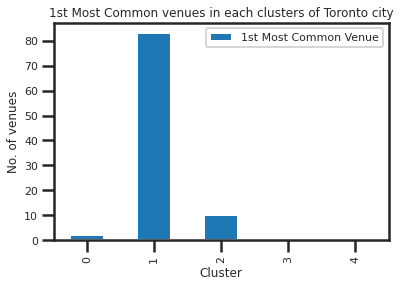

In [134]:
toronto_merged_new.plot(kind="bar")
plt.title("1st Most Common venues in each clusters of Toronto city")
plt.xlabel("Cluster")
plt.ylabel("No. of venues")

In [135]:
# set of clusters
kclusters = 5
newyork_grp_clustering = newyork_onehot_grp.drop(['Borough','Neighborhood'],1)

# run kmeans clustering
kmeans_newyork = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grp_clustering)

# check cluster label generated for each row in the dataframe
kmeans_newyork.labels_

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [136]:
#create a new dataframe that includes the cluster labels along with top 10 venues for each neighborhood
newyork_merged = newyork_grouped.copy()

# add clustering labels
newyork_merged['Cluster Labels'] = kmeans_newyork.labels_

# merge newyork_grouped with newyork_data to add latitude/longitude for each neighborhood
newyork_merged = newyork_merged.join(neighborhoods_venues_sorted_newyork.drop(["Borough","Neighborhood"], 1))

print(newyork_merged.shape)
newyork_merged.head()

(302, 15)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Allerton,40.865788,-73.859319,0,Pizza Place,Deli / Bodega,Supermarket,Spa,Department Store,Gas Station,Breakfast Spot,Fast Food Restaurant,Grocery Store,Check Cashing Service
1,Staten Island,Annadale,40.538114,-74.178549,0,Donut Shop,Electronics Store,Fried Chicken Joint,Mattress Store,Men's Store,Mexican Restaurant,Fast Food Restaurant,Bank,Pet Store,Sandwich Place
2,Staten Island,Arden Heights,40.549286,-74.185887,0,Diner,Pizza Place,Chinese Restaurant,Mexican Restaurant,Deli / Bodega,Sandwich Place,Burger Joint,Pub,Supermarket,Food Truck
3,Staten Island,Arlington,40.635325,-74.165104,0,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Bank,Dessert Shop,Grocery Store,Donut Shop,Food & Drink Shop,Shoe Store
4,Staten Island,Arrochar,40.596313,-74.067124,0,Chinese Restaurant,Italian Restaurant,Breakfast Spot,Paper / Office Supplies Store,Bank,Mexican Restaurant,Gym,Eastern European Restaurant,Pizza Place,Performing Arts Venue


No. of Venues in each cluster of Top Most common venue of New York city

In [137]:
newyork_merged_new = newyork_merged[['Cluster Labels','1st Most Common Venue']]
newyork_merged_new = newyork_merged_new.groupby('Cluster Labels').count()
newyork_merged_new

,1st Most Common Venue
Cluster Labels,
0,272
1,2
2,1
3,25
4,2


Text(0, 0.5, 'No. of venues')

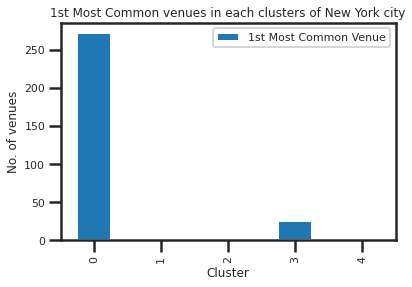

In [138]:
newyork_merged_new.plot(kind="bar")
plt.title("1st Most Common venues in each clusters of New York city")
plt.xlabel("Cluster")
plt.ylabel("No. of venues")

In [139]:
# sort the results by cluster label for Toronto city
toronto_merged.sort_values(['Cluster Labels'], inplace=True)
toronto_merged

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,York,Humewood-Cedarvale,43.693781,-79.428191,0,Pizza Place,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio,Deli / Bodega
59,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0,Pizza Place,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio,Deli / Bodega
0,Scarborough,Agincourt,43.794200,-79.262029,1,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Gym,Coffee Shop,Italian Restaurant,Café,Tennis Court,Diner
61,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1,Clothing Store,Accessories Store,Furniture / Home Store,Coffee Shop,Miscellaneous Shop,Shoe Store,Boutique,Event Space,Vietnamese Restaurant,Women's Store
60,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,1,Baseball Field,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Farmers Market
58,North York,"Northwood Park, York University",43.767980,-79.487262,1,Dog Run,Golf Course,Pool,Mediterranean Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
57,Etobicoke,"Northwest, West Humber - Clairville",43.706748,-79.594054,1,Pizza Place,Pub,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Deli / Bodega
56,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,1,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Cosmetics Shop,Juice Bar,Bank,Bakery,Toy / Game Store
55,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,1,Grocery Store,Park,Athletics & Sports,Home Service,Hotel,Food Truck,Liquor Store,Discount Store,Shopping Mall,Baseball Field
54,Etobicoke,"New Toronto, Mimico South, Humber Bay Shores",43.605647,-79.501321,1,Gym,Restaurant,Japanese Restaurant,Beer Store,Coffee Shop,Art Gallery,Sporting Goods Shop,Chinese Restaurant,Asian Restaurant,Discount Store


In [140]:
# sort the results by cluster label for New York City
newyork_merged.sort_values(['Cluster Labels'], inplace=True)
newyork_merged

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Allerton,40.865788,-73.859319,0,Pizza Place,Deli / Bodega,Supermarket,Spa,Department Store,Gas Station,Breakfast Spot,Fast Food Restaurant,Grocery Store,Check Cashing Service
181,Bronx,Morris Park,40.847549,-73.850402,0,Deli / Bodega,Bank,Chinese Restaurant,Lounge,Supermarket,Spa,Cajun / Creole Restaurant,Flower Shop,Fast Food Restaurant,Liquor Store
182,Bronx,Morrisania,40.823592,-73.901506,0,Donut Shop,Coffee Shop,American Restaurant,Hotel Bar,Lake,Ice Cream Shop,Supermarket,Chinese Restaurant,Gas Station,Bus Station
184,Bronx,Mount Eden,40.843826,-73.916556,0,Thai Restaurant,Mexican Restaurant,Vietnamese Restaurant,Chinese Restaurant,Malay Restaurant,Bubble Tea Shop,Bank,Colombian Restaurant,Sushi Restaurant,Bar
185,Bronx,Mount Hope,40.848842,-73.908299,0,Pizza Place,Chinese Restaurant,Deli / Bodega,Grocery Store,Bank,Breakfast Spot,Fried Chicken Joint,Southern / Soul Food Restaurant,Metro Station,Fast Food Restaurant
186,Manhattan,Murray Hill,40.748303,-73.978332,0,Indian Restaurant,Salon / Barbershop,Pizza Place,Grocery Store,Basketball Court,Dosa Place,Women's Store,Eye Doctor,Factory,Falafel Restaurant
187,Queens,Neponsit,40.572037,-73.857547,0,Hotpot Restaurant,Bubble Tea Shop,Chinese Restaurant,Korean Restaurant,Gym / Fitness Center,Gym,Bakery,Construction & Landscaping,Szechuan Restaurant,Karaoke Bar
188,Staten Island,New Brighton,40.640615,-74.087017,0,Gym,Gym / Fitness Center,Pizza Place,Park,Convenience Store,Thai Restaurant,Yoga Studio,Pharmacy,Boxing Gym,Chinese Restaurant
189,Staten Island,New Dorp,40.572572,-74.116479,0,Grocery Store,Bakery,Pharmacy,Food,Sandwich Place,Sushi Restaurant,Pizza Place,New American Restaurant,Mexican Restaurant,Bagel Shop
191,Brooklyn,New Lots,40.662744,-73.885118,0,Pharmacy,Park,Donut Shop,Mobile Phone Shop,Fast Food Restaurant,Grocery Store,Pizza Place,Gift Shop,Bagel Shop,Bank


Here We have plotted the count of all unique venues in each cluster of 1st most common venues and visualized it using seabron library.

In [141]:
toronto_merged_new1 = toronto_merged[['Cluster Labels','1st Most Common Venue']]
toronto_merged_unique_count = pd.DataFrame(toronto_merged_new1['1st Most Common Venue'].value_counts())
toronto_merged_unique_count.reset_index(inplace=True)
toronto_merged_unique_count.rename(columns={'1st Most Common Venue':'Venue Count', 'index':'1st Most Common Venue'},inplace=True)

toronto_merged_new1 = toronto_merged_new1.merge(toronto_merged_unique_count, on='1st Most Common Venue', how='left')
toronto_merged_new1.head(10)

,Cluster Labels,1st Most Common Venue,Venue Count
0,0,Pizza Place,9
1,0,Pizza Place,9
2,1,Sandwich Place,3
3,1,Clothing Store,4
4,1,Baseball Field,1
5,1,Dog Run,2
6,1,Pizza Place,9
7,1,Clothing Store,4
8,1,Grocery Store,4
9,1,Gym,1


Text(0.5, 1.0, 'No. of unique venues in each cluster of 1st most common venues')

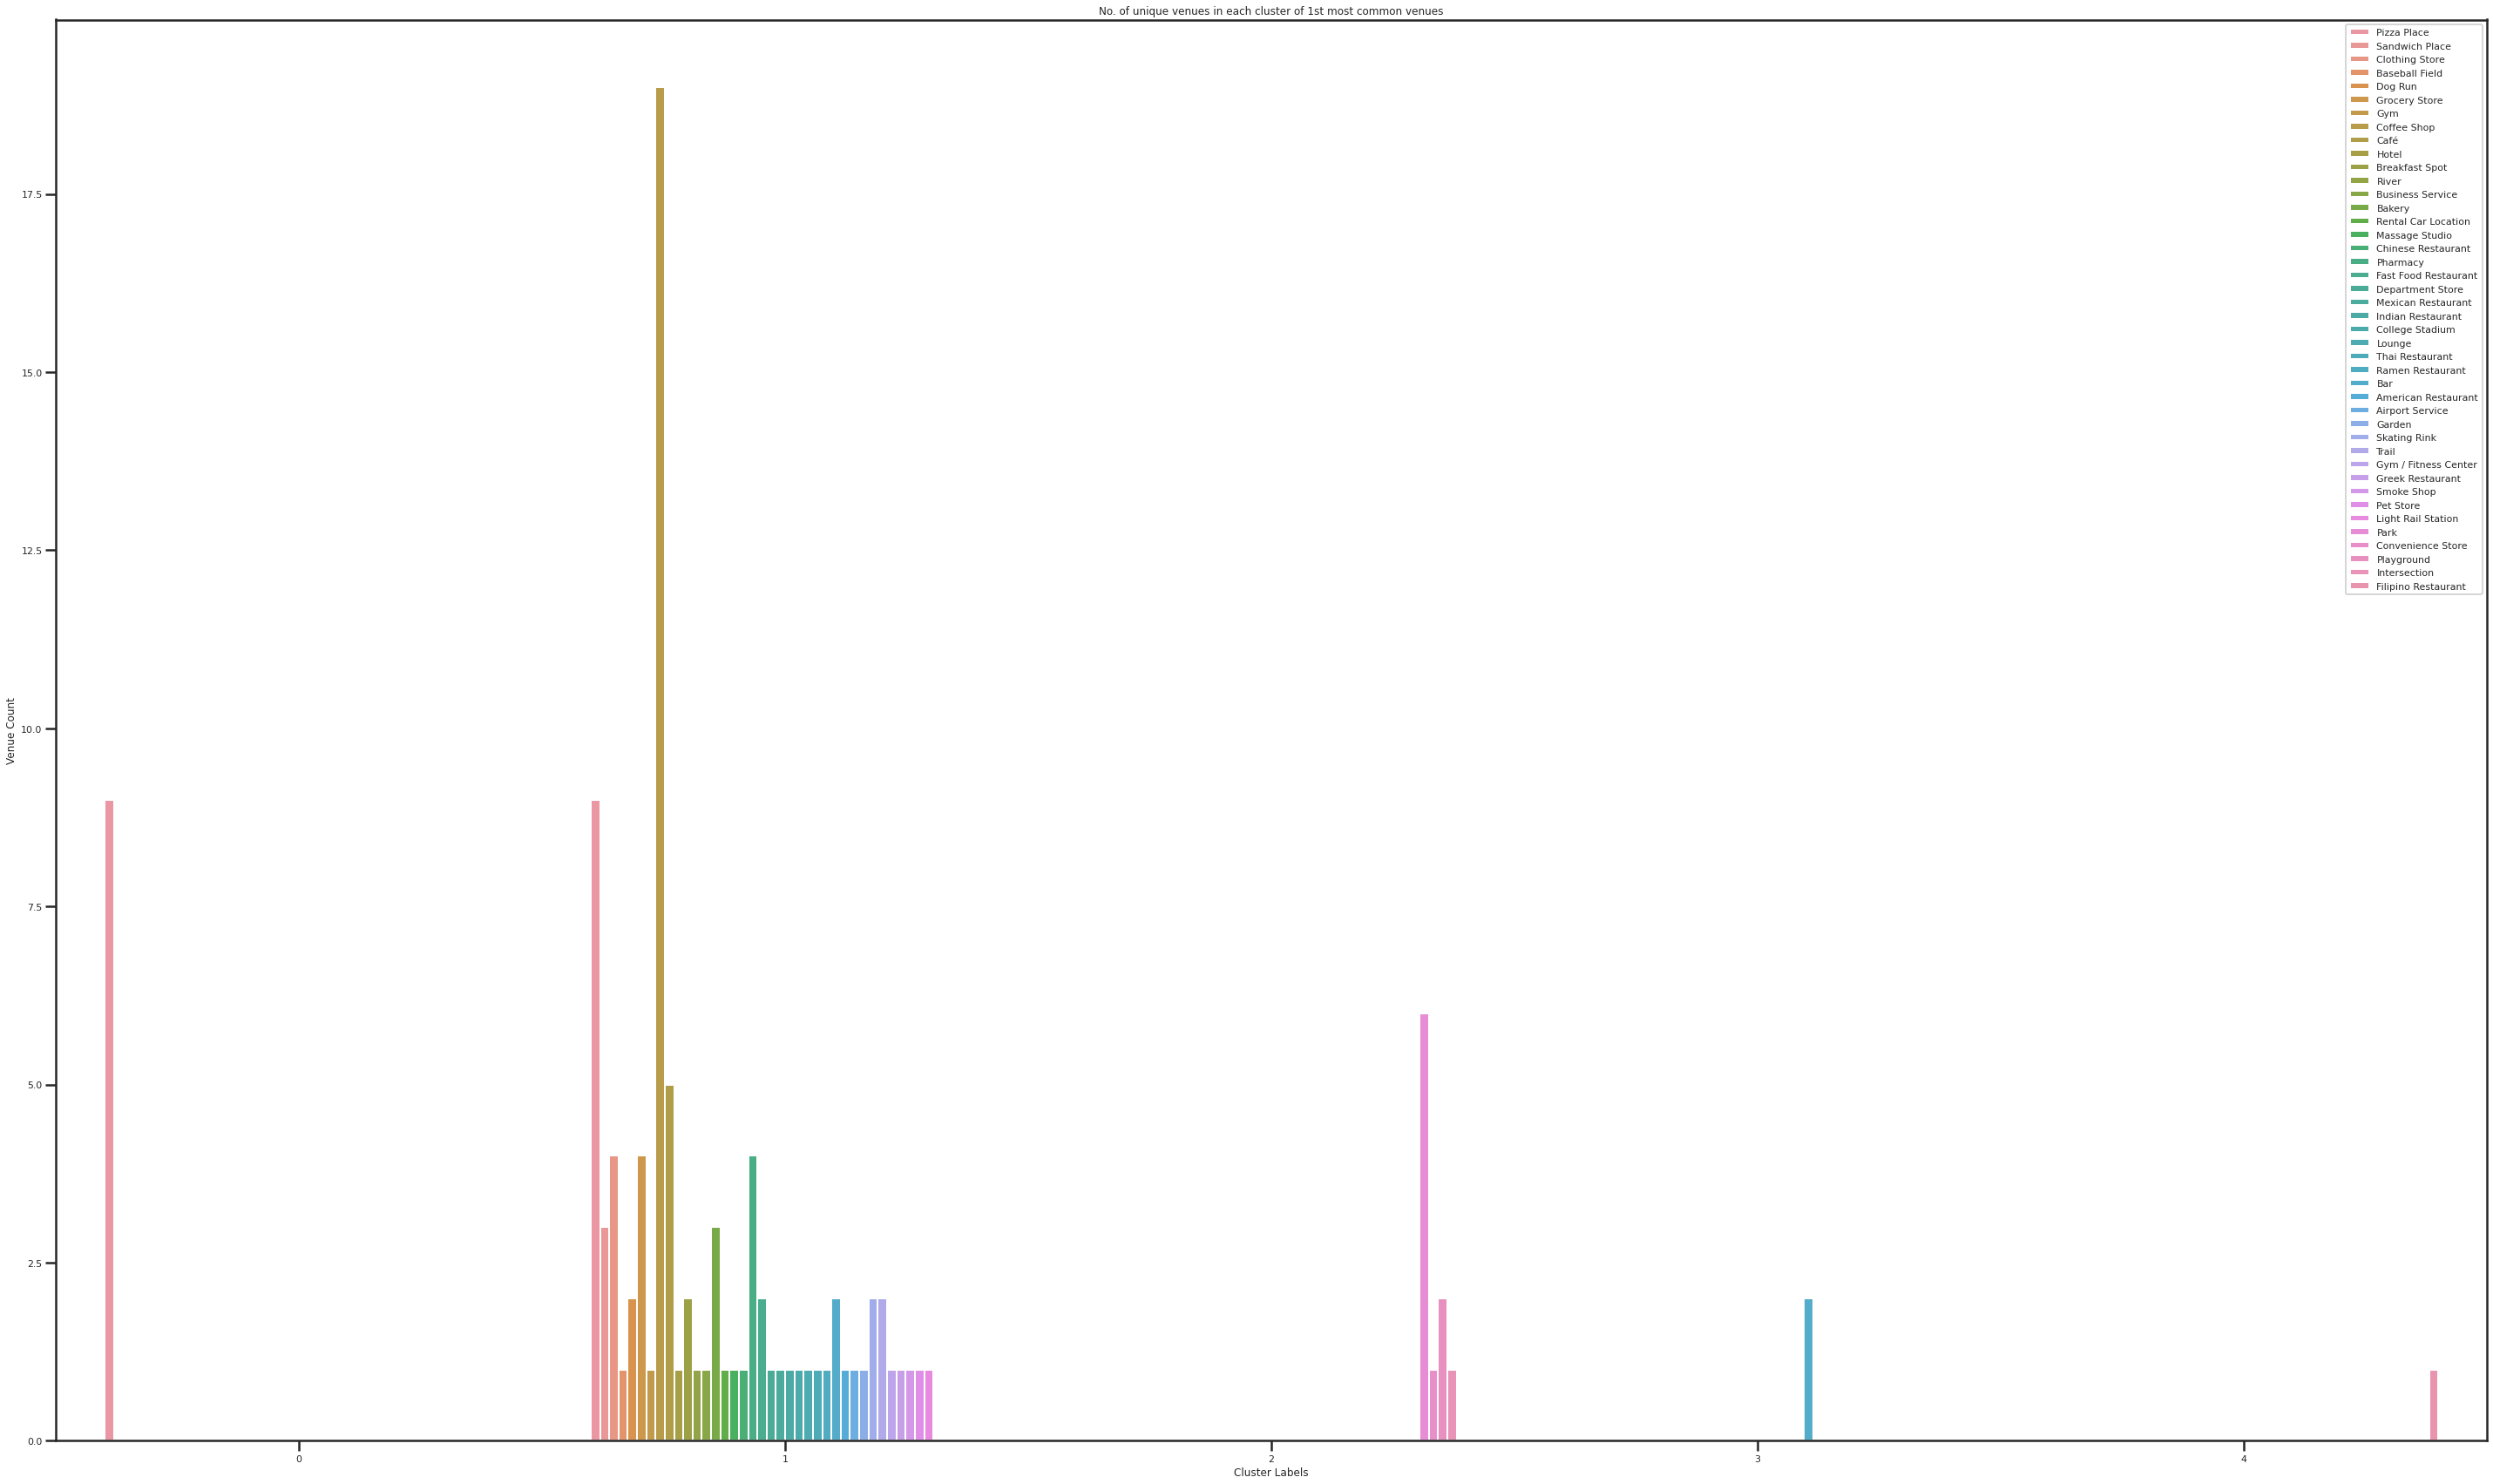

In [142]:
import seaborn as sns

fig_dims = (50,30)
fig, ax = plt.subplots(figsize=fig_dims)
#sns.set(font_scale = 2)
sns.set_style("ticks")
sns.set_context("poster", font_scale = 0.5)
sns.barplot(x='Cluster Labels', y='Venue Count', hue = '1st Most Common Venue', ax=ax, data=toronto_merged_new1)
plt.legend(loc='upper right')
plt.title('No. of unique venues in each cluster of 1st most common venues')

In [143]:
newyork_merged_new1 = newyork_merged[['Cluster Labels','1st Most Common Venue']]
newyork_merged_unique_count = pd.DataFrame(newyork_merged_new1['1st Most Common Venue'].value_counts())
newyork_merged_unique_count.reset_index(inplace=True)
newyork_merged_unique_count.rename(columns={'1st Most Common Venue':'Venue Count', 'index':'1st Most Common Venue'},inplace=True)

newyork_merged_new1 = newyork_merged_new1.merge(newyork_merged_unique_count, on='1st Most Common Venue', how='left')
newyork_merged_new1.head(15)

,Cluster Labels,1st Most Common Venue,Venue Count
0,0,Pizza Place,29
1,0,Deli / Bodega,30
2,0,Donut Shop,5
3,0,Thai Restaurant,1
4,0,Pizza Place,29
5,0,Indian Restaurant,2
6,0,Hotpot Restaurant,1
7,0,Gym,2
8,0,Grocery Store,9
9,0,Pharmacy,11


Text(0.5, 1.0, 'No. of unique venues in each cluster of 1st most common venues')

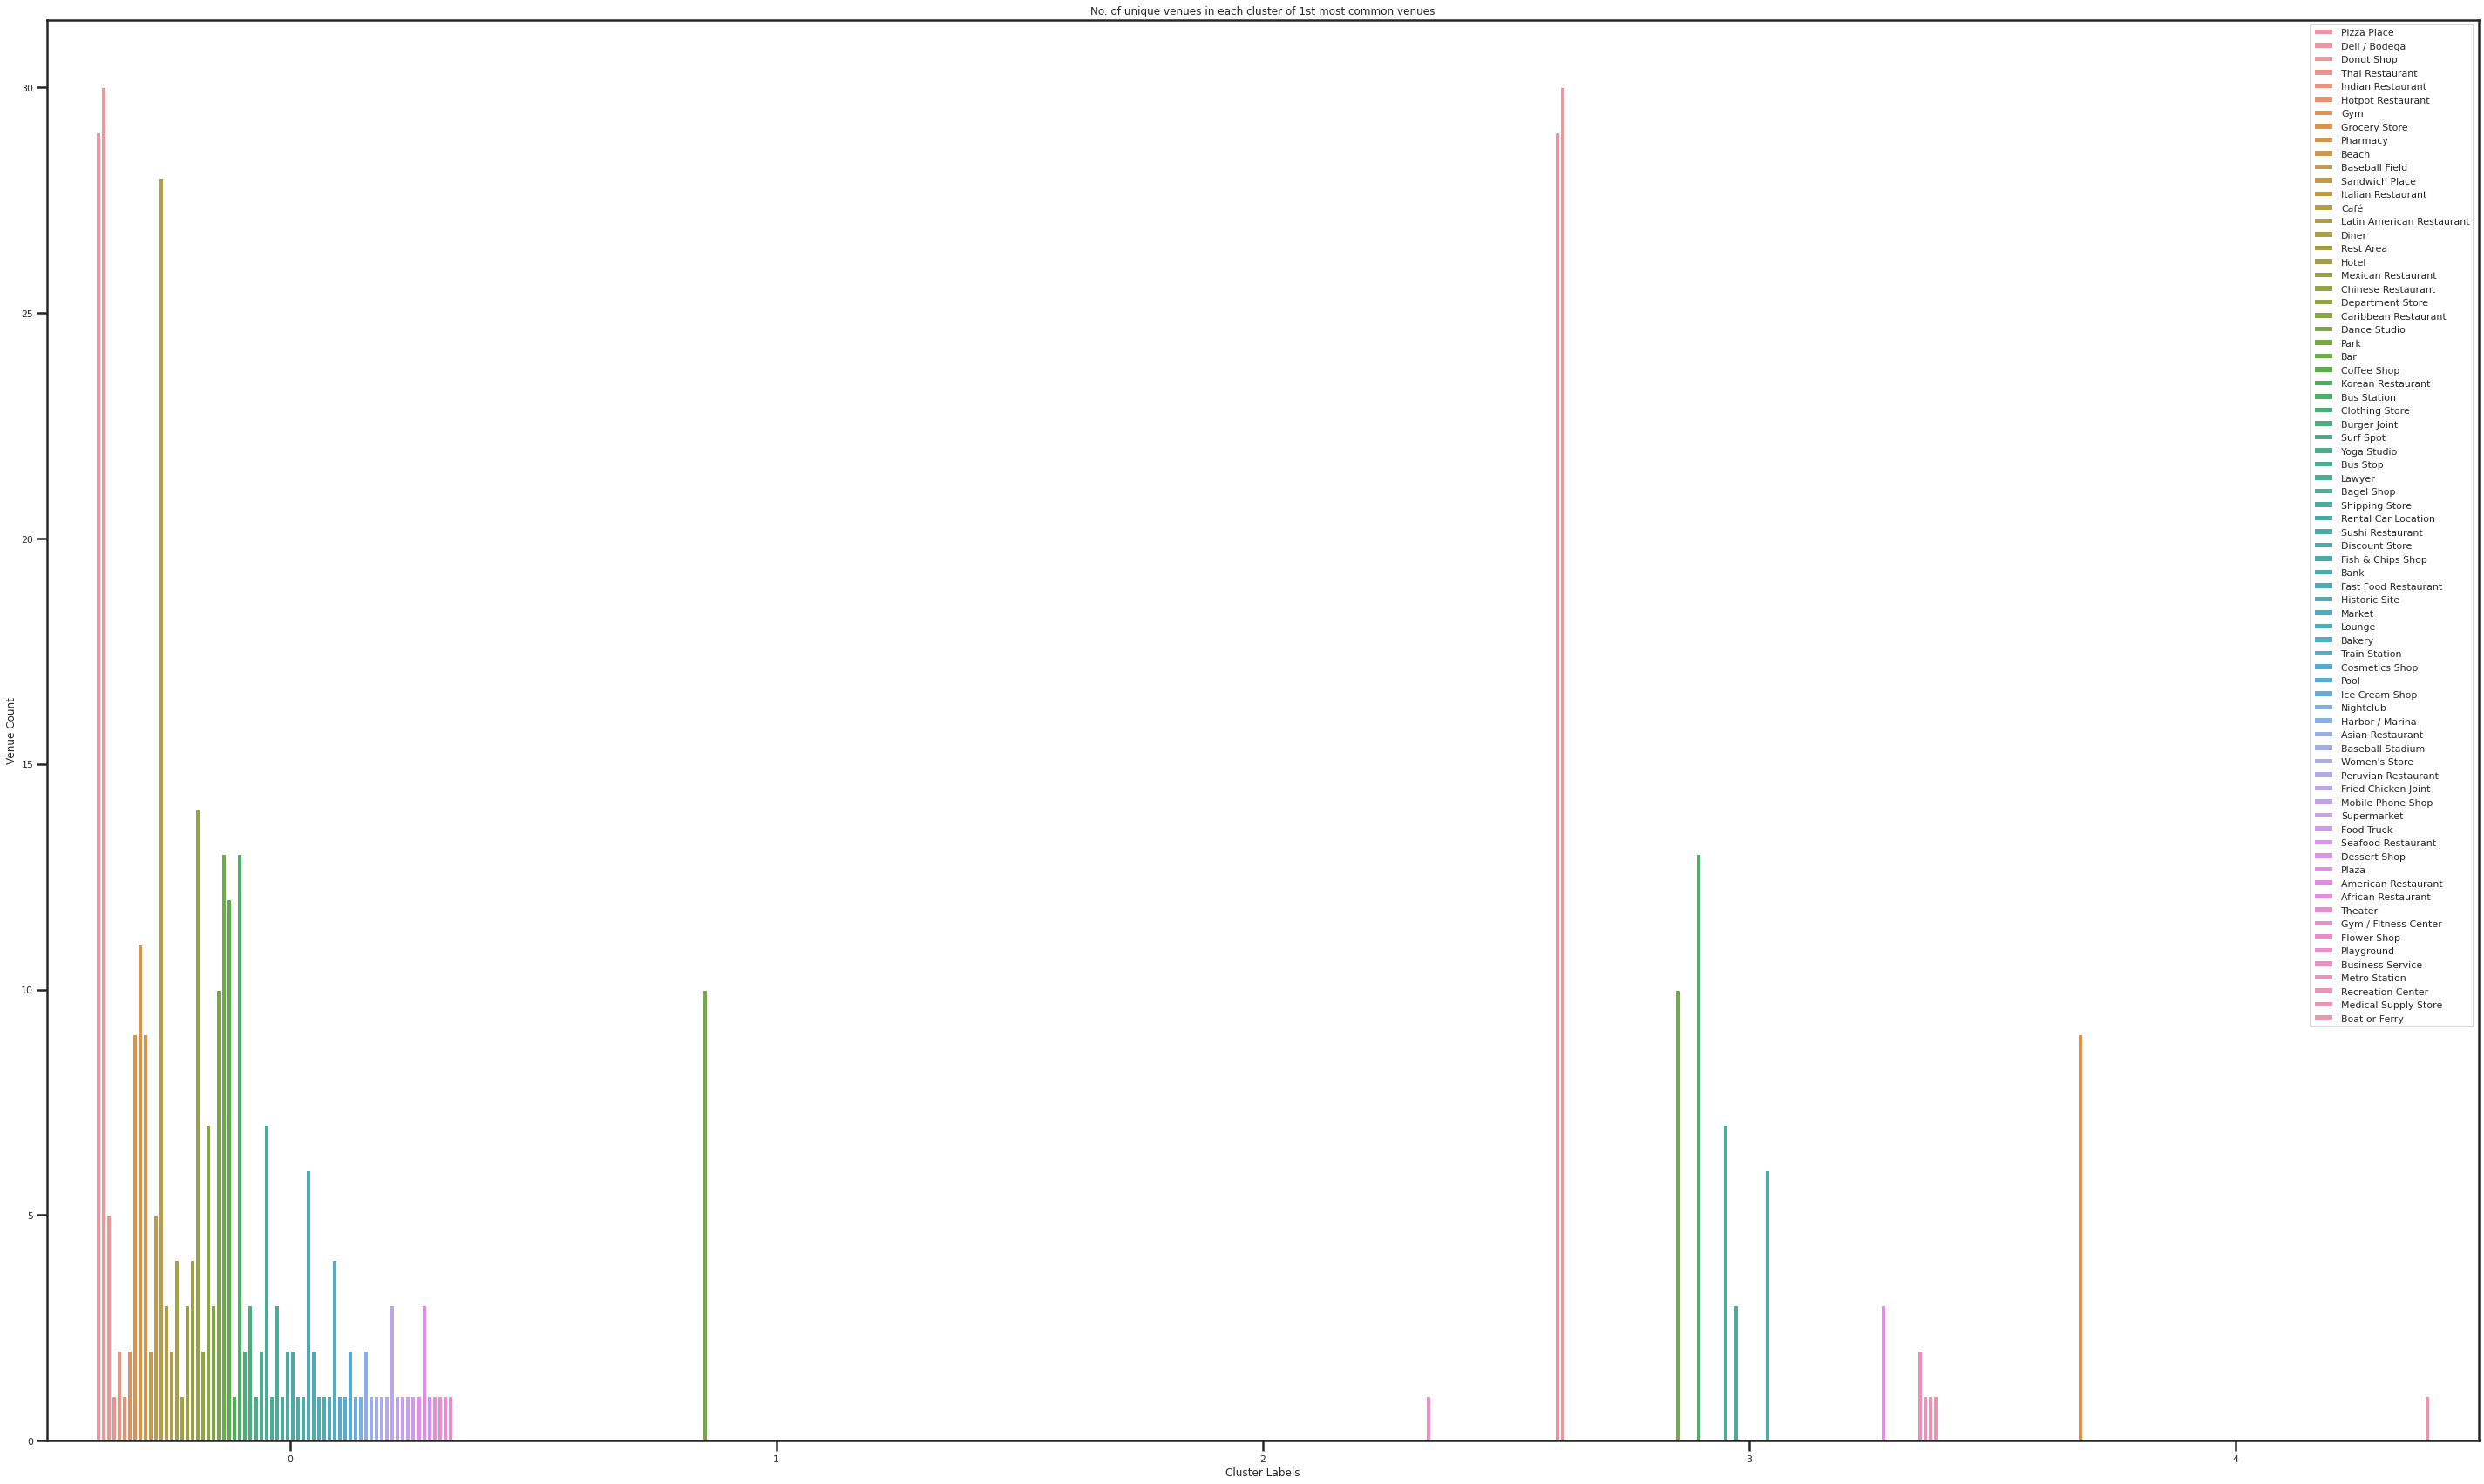

In [144]:
import seaborn as sns

fig_dims = (50,30)
fig, ax = plt.subplots(figsize=fig_dims)
#sns.set(font_scale = 2)
sns.set_style("ticks")
sns.set_context("poster", font_scale = 0.5)
sns.barplot(x='Cluster Labels', y='Venue Count', hue = '1st Most Common Venue', ax=ax, data=newyork_merged_new1)
plt.legend(loc='upper right')
plt.title('No. of unique venues in each cluster of 1st most common venues')

##**7. Finally let's visualise the resulting clusters**

Finally the visualization for both cities’ neighborhood clusters is done through the folium library.

Here is the map of both cities containing clusters of top 10 most common venues obtained after visualising the clustered dataset.


In [145]:
# create map of Toronto
map_clusters_toronto = folium.Map(location=[latitude_t, longitude_t], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, neigh, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'],
                                         toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup("{} : {} - Cluster {}".format(bor,neigh,cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_toronto)
       
map_clusters_toronto

In [146]:
# create map of New York
map_clusters_newyork = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)
print(kclusters)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bor, neigh, cluster in zip(newyork_merged['Neighborhood Latitude'], newyork_merged['Neighborhood Longitude'],
                                         newyork_merged['Borough'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup("{} : {} - Cluster {}".format(bor,neigh,cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_newyork)
       
map_clusters_newyork

5


##**8. Examine Clusters**

The results obtained after applying the k-means clustering on both the dataset show that we can categorise the neighborhoods into 5 clusters based on the frequency of occurrence of venues.

###Cluster no. 1

**Toronto :** (Red Cluster)

In [147]:
toronto_merged.loc[toronto_merged['Cluster Labels']==0, toronto_merged.columns[[1]+list(range(5,toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,Humewood-Cedarvale,Pizza Place,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio,Deli / Bodega
59,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Pizza Place,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio,Deli / Bodega


**New York :** (Red Cluster)

In [148]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Spa,Department Store,Gas Station,Breakfast Spot,Fast Food Restaurant,Grocery Store,Check Cashing Service
181,Morris Park,Deli / Bodega,Bank,Chinese Restaurant,Lounge,Supermarket,Spa,Cajun / Creole Restaurant,Flower Shop,Fast Food Restaurant,Liquor Store
182,Morrisania,Donut Shop,Coffee Shop,American Restaurant,Hotel Bar,Lake,Ice Cream Shop,Supermarket,Chinese Restaurant,Gas Station,Bus Station
184,Mount Eden,Thai Restaurant,Mexican Restaurant,Vietnamese Restaurant,Chinese Restaurant,Malay Restaurant,Bubble Tea Shop,Bank,Colombian Restaurant,Sushi Restaurant,Bar
185,Mount Hope,Pizza Place,Chinese Restaurant,Deli / Bodega,Grocery Store,Bank,Breakfast Spot,Fried Chicken Joint,Southern / Soul Food Restaurant,Metro Station,Fast Food Restaurant
186,Murray Hill,Indian Restaurant,Salon / Barbershop,Pizza Place,Grocery Store,Basketball Court,Dosa Place,Women's Store,Eye Doctor,Factory,Falafel Restaurant
187,Neponsit,Hotpot Restaurant,Bubble Tea Shop,Chinese Restaurant,Korean Restaurant,Gym / Fitness Center,Gym,Bakery,Construction & Landscaping,Szechuan Restaurant,Karaoke Bar
188,New Brighton,Gym,Gym / Fitness Center,Pizza Place,Park,Convenience Store,Thai Restaurant,Yoga Studio,Pharmacy,Boxing Gym,Chinese Restaurant
189,New Dorp,Grocery Store,Bakery,Pharmacy,Food,Sandwich Place,Sushi Restaurant,Pizza Place,New American Restaurant,Mexican Restaurant,Bagel Shop
191,New Lots,Pharmacy,Park,Donut Shop,Mobile Phone Shop,Fast Food Restaurant,Grocery Store,Pizza Place,Gift Shop,Bagel Shop,Bank


###Cluster no. 2

**Toronto :** (Purple Cluster)

In [149]:
toronto_merged.loc[toronto_merged['Cluster Labels']==1, toronto_merged.columns[[1]+list(range(5,toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Gym,Coffee Shop,Italian Restaurant,Café,Tennis Court,Diner
61,"Parkview Hill, Woodbine Gardens",Clothing Store,Accessories Store,Furniture / Home Store,Coffee Shop,Miscellaneous Shop,Shoe Store,Boutique,Event Space,Vietnamese Restaurant,Women's Store
60,"Parkdale, Roncesvalles",Baseball Field,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Farmers Market
58,"Northwood Park, York University",Dog Run,Golf Course,Pool,Mediterranean Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
57,"Northwest, West Humber - Clairville",Pizza Place,Pub,Sushi Restaurant,Japanese Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Deli / Bodega
56,"North Toronto West, Lawrence Park",Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Cosmetics Shop,Juice Bar,Bank,Bakery,Toy / Game Store
55,"North Park, Maple Leaf Park, Upwood Park",Grocery Store,Park,Athletics & Sports,Home Service,Hotel,Food Truck,Liquor Store,Discount Store,Shopping Mall,Baseball Field
54,"New Toronto, Mimico South, Humber Bay Shores",Gym,Restaurant,Japanese Restaurant,Beer Store,Coffee Shop,Art Gallery,Sporting Goods Shop,Chinese Restaurant,Asian Restaurant,Discount Store
53,"Moore Park, Summerhill East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Pharmacy,Butcher,Pub,Sushi Restaurant,Liquor Store,Fast Food Restaurant
52,"Mimico NW, The Queensway West, South of Bloor,...",Café,Bank,Chinese Restaurant,Japanese Restaurant,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


**New York :** (Purple Cluster)

In [150]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
294,Willowbrook,Park,Women's Store,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
230,Richmond Town,Park,Women's Store,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


###Cluster no. 3

**Toronto :** (Light-blue Cluster)

In [151]:
toronto_merged.loc[toronto_merged['Cluster Labels']==2, toronto_merged.columns[[1]+list(range(5,toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,"Willowdale, Willowdale East",Park,Women's Store,Pool,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop
96,York Mills West,Convenience Store,Park,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio
80,The Beaches,Playground,Park,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop
69,"Runnymede, Swansea",Park,Convenience Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio
66,Rosedale,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
64,"Regent Park, Harbourfront",Park,Construction & Landscaping,Food & Drink Shop,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop
33,"Golden Mile, Clairlea, Oakridge",Intersection,Park,Convenience Store,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
22,Don Mills,Park,Trail,Playground,Yoga Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Playground,Park,Tennis Court,Yoga Studio,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
3,Bayview Village,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


**New York :** (Light-blue Cluster)

In [152]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
168,Marine Park,Playground,Women's Store,Fish Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


###Cluster no. 4

**Toronto :** (Teal Cluster)

In [153]:
toronto_merged.loc[toronto_merged['Cluster Labels']==3, toronto_merged.columns[[1]+list(range(5,toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
81,"The Danforth West, Riverdale",Bar,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Farmers Market


**New York :** (Teal Cluster)

In [154]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,Dyker Heights,Plaza,Burger Joint,Bagel Shop,Park,Golf Course,Grocery Store,Fish Market,Falafel Restaurant,Farm,Farmers Market
104,Fort Greene,Business Service,Harbor / Marina,Food,Asian Restaurant,Women's Store,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
48,Charleston,Bus Station,Park,Bus Stop,Pizza Place,Metro Station,Coffee Shop,Scenic Lookout,Bank,Lounge,Sandwich Place
183,Mott Haven,Metro Station,Deli / Bodega,Hotel,Gift Shop,Farm,Park,Skate Park,Seafood Restaurant,Scenic Lookout,Pizza Place
233,Riverdale,Bus Station,Donut Shop,Park,Chinese Restaurant,Liquor Store,Check Cashing Service,Gym,Fast Food Restaurant,Sandwich Place,Gas Station
217,Prince's Bay,Pizza Place,Bowling Alley,Japanese Restaurant,Bus Station,Halal Restaurant,Bar,Supermarket,Park,Scenic Lookout,Playground
7,Astoria Heights,Bus Station,Grocery Store,Chinese Restaurant,Bakery,Lawyer,Gift Shop,Food,Caribbean Restaurant,Gym,Liquor Store
8,Auburndale,Park,Boat or Ferry,South American Restaurant,Bus Stop,Pool,Convenience Store,Grocery Store,Farm,Farmers Market,Fast Food Restaurant
9,Bath Beach,Bus Station,Baseball Field,Restaurant,Pizza Place,Grocery Store,Fast Food Restaurant,Park,Pharmacy,Bagel Shop,Fried Chicken Joint
204,Ozone Park,Bank,Bus Station,Pizza Place,Sushi Restaurant,Playground,Burger Joint,Smoke Shop,Food,Dance Studio,Deli / Bodega


###Cluster no. 5

**Toronto :** (Orange Cluster)

In [155]:
toronto_merged.loc[toronto_merged['Cluster Labels']==4, toronto_merged.columns[[1]+list(range(5,toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Leaside,Filipino Restaurant,Yoga Studio,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant


**New York :** (Orange Cluster)

In [156]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[1] + list(range(5, newyork_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
266,Sunset Park,Boat or Ferry,Women's Store,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
259,St. George,Grocery Store,Boat or Ferry,Women's Store,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


##**9. Top Venues by Neighborhood Cluster : Toronto versus New York**

One of my aims was also to show the top 5 venues information for each cluster of both the cities in a single table. This will help us to easily compare and analyze the clusters of both the cities.



Set up the dataframes for Top 5 by Cluster

In [157]:
toronto_top5 = toronto_merged[['Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue','4th Most Common Venue', '5th Most Common Venue',]]
toronto_top5 = toronto_top5.dropna()
toronto_top5['Cluster Labels'] = toronto_top5['Cluster Labels'].astype(int)
print(toronto_top5.shape)
toronto_top5.head()

(97, 6)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
40,0,Pizza Place,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant
59,0,Pizza Place,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant
0,1,Sandwich Place,Dessert Shop,Pizza Place,Sushi Restaurant,Gym
61,1,Clothing Store,Accessories Store,Furniture / Home Store,Coffee Shop,Miscellaneous Shop
60,1,Baseball Field,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner


In [158]:
top5_toronto = toronto_top5.pivot_table(values=('1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue',
                                               '5th Most Common Venue'),columns='Cluster Labels', aggfunc='first')

top5_toronto.rename(columns={0:'Toronto Cluster 0', 1:'Toronto Cluster 1', 2:'Toronto Cluster 2',
                              3:'Toronto Cluster 3',4:'Toronto Cluster 4'}, inplace=True)
top5_toronto

Cluster Labels,Toronto Cluster 0,Toronto Cluster 1,Toronto Cluster 2,Toronto Cluster 3,Toronto Cluster 4
1st Most Common Venue,Pizza Place,Sandwich Place,Park,Bar,Filipino Restaurant
2nd Most Common Venue,Dog Run,Dessert Shop,Women's Store,Yoga Studio,Yoga Studio
3rd Most Common Venue,Department Store,Pizza Place,Pool,Doner Restaurant,Department Store
4th Most Common Venue,Dessert Shop,Sushi Restaurant,Dog Run,Dim Sum Restaurant,Ethiopian Restaurant
5th Most Common Venue,Dim Sum Restaurant,Gym,Dessert Shop,Diner,Electronics Store


In [159]:
newyork_top5 = newyork_merged[['Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue','4th Most Common Venue', '5th Most Common Venue',]]
newyork_top5 = newyork_top5.dropna()
newyork_top5['Cluster Labels'] = newyork_top5['Cluster Labels'].astype(int)
print(newyork_top5.shape)
newyork_top5.head()

(302, 6)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Pizza Place,Deli / Bodega,Supermarket,Spa,Department Store
181,0,Deli / Bodega,Bank,Chinese Restaurant,Lounge,Supermarket
182,0,Donut Shop,Coffee Shop,American Restaurant,Hotel Bar,Lake
184,0,Thai Restaurant,Mexican Restaurant,Vietnamese Restaurant,Chinese Restaurant,Malay Restaurant
185,0,Pizza Place,Chinese Restaurant,Deli / Bodega,Grocery Store,Bank


In [160]:
top5_newyork = newyork_top5.pivot_table(values=('1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue',
                                               '5th Most Common Venue'),columns='Cluster Labels', aggfunc='first')

top5_newyork.rename(columns={0:'New York Cluster 0', 1:'New York Cluster 1', 2:'New York Cluster 2',
                              3:'New York Cluster 3',4:'New York Cluster 4'}, inplace=True)
top5_newyork

Cluster Labels,New York Cluster 0,New York Cluster 1,New York Cluster 2,New York Cluster 3,New York Cluster 4
1st Most Common Venue,Pizza Place,Park,Playground,Plaza,Boat or Ferry
2nd Most Common Venue,Deli / Bodega,Women's Store,Women's Store,Burger Joint,Women's Store
3rd Most Common Venue,Supermarket,Exhibit,Fish Market,Bagel Shop,Flower Shop
4th Most Common Venue,Spa,Factory,Eye Doctor,Park,Factory
5th Most Common Venue,Department Store,Falafel Restaurant,Factory,Golf Course,Falafel Restaurant


Top 5 venues by Neighborhood Clusters in Toronto vs New York

In [161]:
toronto_vs_newyork = pd.concat([top5_toronto, top5_newyork], axis=1)
clm = ['--------','--------','--------','--------','--------']
toronto_vs_newyork['|'] = clm
toronto_vs_newyork = toronto_vs_newyork[['Toronto Cluster 0','Toronto Cluster 1','Toronto Cluster 2','Toronto Cluster 3','Toronto Cluster 4', '|',
               'New York Cluster 0','New York Cluster 1','New York Cluster 2','New York Cluster 3','New York Cluster 4']]
toronto_vs_newyork

Cluster Labels,Toronto Cluster 0,Toronto Cluster 1,Toronto Cluster 2,Toronto Cluster 3,Toronto Cluster 4,|,New York Cluster 0,New York Cluster 1,New York Cluster 2,New York Cluster 3,New York Cluster 4
1st Most Common Venue,Pizza Place,Sandwich Place,Park,Bar,Filipino Restaurant,--------,Pizza Place,Park,Playground,Plaza,Boat or Ferry
2nd Most Common Venue,Dog Run,Dessert Shop,Women's Store,Yoga Studio,Yoga Studio,--------,Deli / Bodega,Women's Store,Women's Store,Burger Joint,Women's Store
3rd Most Common Venue,Department Store,Pizza Place,Pool,Doner Restaurant,Department Store,--------,Supermarket,Exhibit,Fish Market,Bagel Shop,Flower Shop
4th Most Common Venue,Dessert Shop,Sushi Restaurant,Dog Run,Dim Sum Restaurant,Ethiopian Restaurant,--------,Spa,Factory,Eye Doctor,Park,Factory
5th Most Common Venue,Dim Sum Restaurant,Gym,Dessert Shop,Diner,Electronics Store,--------,Department Store,Falafel Restaurant,Factory,Golf Course,Falafel Restaurant


##**10. Results and Discussion**

The clustered map and the above table will allow us to identify which neighborhoods have higher concentration of venues and places to visit while which have lower concentration.

The results show that there is a similarity for both cities' first few common places. The 1st cluster and 5th cluster of Toronto city and New York city respectively, shows that they have a very high concentration of venues around their neighborhoods and that’s why they can be compared directly. But the results may also show that there are many clusters that do not have direct comparison.

Based on this, it will help us to answer the question as to which neighborhoods are most suitable based on our requirements.



To the future,

Maruf Ansari


**Thank You**